#### Sideloading data

In this notebook we'll learn how to add data from sources other than the automated ones into pyWaPOR. We start by creating NDVI, Albedo and LST maps from a manually downloaded Landsat tile and then continue to incorporate that data into `pre_et_look`.

##### Landsat

First we install pywapor, in case it's not installed yet.

In [1]:
!pip install pywapor==3.1.5 --quiet

Then we'll define the usual parameters.

In [2]:
import pywapor
import os

project_folder = r"/Users/hmcoerver/pywapor_notebooks_4"
latlim = [28.9, 29.7]
lonlim = [30.2, 31.2]
timelim = ["2021-07-01", "2021-07-11"]

The function that transforms Landsat Collection-2 Level-2 scenes into `ndvi`, `r0` and `lst` maps takes one mandatory input variable, which describes the folder path in which it should look for `tar`-files containing Landsat scenes. So let's start by defining that variable.

In [3]:
landsat_folder = os.path.join(project_folder, "LANDSAT")

For now the folder is empty (and probably doesn't even exist yet). Normally, you would put the files you've downloaded, from for example the [Earth Explorer](https://earthexplorer.usgs.gov), in this folder. But for this notebook we'll use an (much smaller) example file, that we can download like this.

In [4]:
test_file = pywapor.collect.product.Landsat.C2L2SP.dl_landsat_test(landsat_folder)

We can check the contents of our `landsat_folder` like this.

In [5]:
!ls $landsat_folder

LE07_L2SP_177040_20210707_20210802_02_T1.tar


Now that we have our Landsat scene, we can convert it into `ndvi`, `r0` and `lst` maps. 

In [6]:
ds = pywapor.collect.product.Landsat.C2L2SP.main(landsat_folder)

the output, `ds`, contains a `xr.Dataset` with 3 variables.

In [7]:
ds

<xarray.Dataset>
Dimensions:      (x: 1933, y: 1834, time: 1)
Coordinates:
  * x            (x) float64 30.37 30.37 30.37 30.37 ... 30.93 30.93 30.93 30.93
  * y            (y) float64 29.66 29.66 29.66 29.66 ... 29.13 29.13 29.13 29.13
  * time         (time) datetime64[ns] 2021-07-07T07:33:59.680840800
    spatial_ref  int64 ...
Data variables:
    lst          (time, y, x) float64 dask.array<chunksize=(1, 1834, 1933), meta=np.ndarray>
    ndvi         (time, y, x) float64 dask.array<chunksize=(1, 1834, 1933), meta=np.ndarray>
    r0           (time, y, x) float64 dask.array<chunksize=(1, 1834, 1933), meta=np.ndarray>

Let's have a quick look at them before we continue.

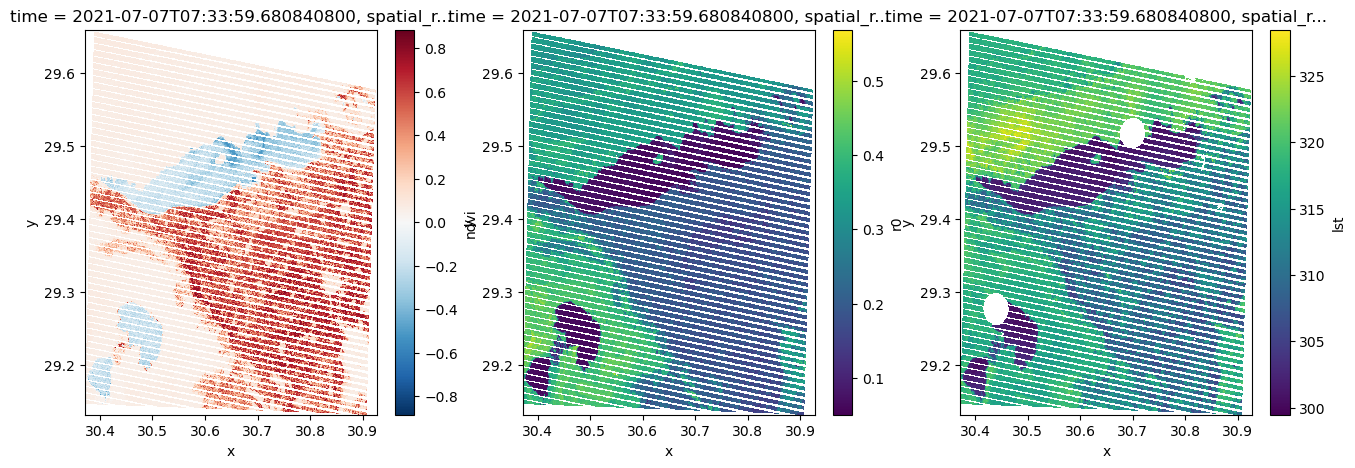

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(1)
axs = fig.subplots(1, 3).flatten()
fig.set_size_inches(16, 5)

ds.ndvi.isel(time=0).plot(ax = axs[0])
ds.r0.isel(time=0).plot(ax = axs[1])
ds.lst.isel(time=0).plot(ax = axs[2])

That doesn't look good, does it? Landsat 7 has some scanline problems, as a result of which unfortunately many scenes have stripes of missing data.

Also notice the circles of missing data in the lst-map. Each level-2 Landsat scene comes with a map indicating the uncertainty in the given lst-values. By default, `pywapor.collect.Landsat.C2L2SP.main` automatically masks out any `lst` values that have an uncertainty greater than 2.5 K. You can adjust this value by passing the keyword argument `max_lst_uncertainty` to the function. For example like this: `ds = pywapor.collect.Landsat.C2L2SP.main(landsat_folder, max_lst_uncertainty = 5.0)`.

We can check our Landsat folder again.

In [9]:
%ls $landsat_folder

LANDSAT.nc
LE07_L2SP_177040_20210707_20210802_02_T1.tar


As you can see, there is a new netcdf file.

##### Gap Filling

In order to deal with the scanline problem, we can add a gap filling function to our workflow. Here we will use GDALs [fillnodata](https://gdal.org/programs/gdal_fillnodata.html) function.

In [10]:
import xarray as xr
import numpy as np
from osgeo import gdal

def gap_fill(ds, var, maxSearchDist = 5):

    # Create an empty xr.DataArray to store our results.
    new_data = xr.ones_like(ds[var]) * np.nan

    # Since gdal.FillNodata can only handle one band at a time, we have to loop over each scene.
    for t in ds.time:

        # Select the data at time t.
        da_slice = ds[var].sel(time = t)

        # Convert the data to a np.array with numeric no-data-value
        shape = da_slice.shape
        data = np.copy(da_slice.values)
        mask = np.isnan(data)
        ndv = -9999
        data[mask] = ndv

        # Create an in-memory gdal.Dataset.
        driver = gdal.GetDriverByName("MEM")
        gdal_ds = driver.Create('', shape[1], shape[0], 1, gdal.GDT_Float32)
        band = gdal_ds.GetRasterBand(1)
        band.SetNoDataValue(ndv)
        band.WriteArray(data)

        # Pass the gdal.Dataset to the gap filling algorithm.
        _ = gdal.FillNodata(targetBand = band, maskBand = None, 
                            maxSearchDist = maxSearchDist, smoothingIterations = 0)

        # Read the results and replace the no-data-values again.
        array = band.ReadAsArray()
        array[array == ndv] = np.nan

        # Release the gdal.Dataset.
        gdal_ds = gdal_ds.FlushCache()

        # Put the results back into the xr.DataArray.
        new_data = xr.where(new_data.time == t, array, new_data)

    ds[var] = new_data

    return ds

Now that we have defined the function, lets apply it to our `ndvi`.

In [11]:
ds = gap_fill(ds, "ndvi")

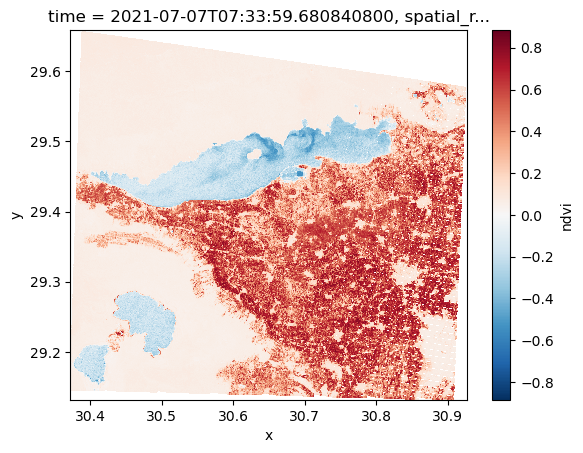

In [12]:
ds.ndvi.isel(time=0).plot()

##### Sideloading

Next, we'll include this data in `pre_et_look`, to do so we can adjust our `sources` variable.

As we have seen before, each variable in `sources` contains a key called `source`, which contains a list with the products that need to be included for the respective variable. `sources` could for example look like this.

In [13]:
et_look_sources = {
    'ndvi': {
            'products': [
                            {
                            'source': 'MODIS',
                            'product_name': 'MOD13Q1.061',
                            'enhancers': 'default',
                            },
                            {
                            'source': 'MODIS', 
                            'product_name': 'MYD13Q1.061', 
                            'enhancers': 'default'
                            }
                        ],
            'composite_type': 'mean',
            'temporal_interp': 'linear',
            'spatial_interp': 'nearest'
            },
}

Instead of providing a string as `source` inside this dictionary however, it is also possible to provide a function instead.

This function needs to meet certain criteria, a template function looks like this.

In [14]:
import xarray as xr

def my_custom_source(folder, latlim, lonlim, timelim, product_name, 
                        req_vars, post_processors):
    ...
    ds = xr.Dataset()
    return ds

So within the function you can add whatever process you want to execute. The function can also use the arguments specified, but doesnt have to. It must return an `xr.Dataset` that contains at least the variable for which it is specified in `sources`.

Applying this to the steps we've executed above, we can create a function that downloads our dummy Landsat data, processes it into a `xr.Dataset` and returns that dataset.

In [15]:
def LS(folder, **kwargs):
    landsat_folder = os.path.join(folder, "LANDSAT")
    _ = pywapor.collect.product.Landsat.C2L2SP.dl_landsat_test(landsat_folder)
    ds = pywapor.collect.product.Landsat.C2L2SP.main(landsat_folder)
    ds = gap_fill(ds, "ndvi")
    return ds

Note that the function only uses the `folder` argument. the term `**kwargs` is added to discard the other arguments that are not used in this (very simple) function.

Now that we have the function, we can add it to sources.

In [16]:
et_look_sources["ndvi"]["products"].append({
                                            'source': LS,
                                            'product_name': 'LANDSAT',
                                            'enhancers': 'default',
                                            'is_example': True
})

print(et_look_sources)

{'ndvi': {'products': [{'source': 'MODIS', 'product_name': 'MOD13Q1.061', 'enhancers': 'default'}, {'source': 'MODIS', 'product_name': 'MYD13Q1.061', 'enhancers': 'default'}, {'source': <function LS at 0x17f75df30>, 'product_name': 'LANDSAT', 'enhancers': 'default', 'is_example': True}], 'composite_type': 'mean', 'temporal_interp': 'linear', 'spatial_interp': 'nearest'}}


Next, we can run `pywapor.pre_et_look.main`, you'll see that `ndvi` will be calculated from three different products.

In [17]:
ds = pywapor.pre_et_look.main(project_folder, latlim, lonlim, timelim, 
                                sources = et_look_sources)

> PRE_ET_LOOK
    --> Collecting `ndvi` from `MODIS.MOD13Q1.061`.
        --> Applying 'mask_qa' to `ndvi`.              
        --> Saving merged data.
            > peak-memory-usage: 2.5MB, execution-time: 0:00:02.073976.
            > chunksize|dimsize: [time: 1|1, y: 418|418, x: 523|523]
            > timesize: 1 [2021-07-04T00:00, ..., 2021-07-04T00:00]
    --> Collecting `ndvi` from `MODIS.MYD13Q1.061`.
        --> Applying 'mask_qa' to `ndvi`.              
        --> Saving merged data.
            > peak-memory-usage: 5.0MB, execution-time: 0:00:02.051880.
            > chunksize|dimsize: [time: 2|2, y: 418|418, x: 523|523]
            > timesize: 2 [2021-06-26T00:00, ..., 2021-07-12T00:00]
    --> Collecting `ndvi` from `LS.LANDSAT`.
        --> Creating example dataset.
            > peak-memory-usage: 23.4KB, execution-time: 0:00:00.014375.
            > chunksize|dimsize: []
        --> Processing `LE07_L2SP_177040_20210707_20210802_02_T1.tar`.
            > peak-memory

In [18]:
ds

<xarray.Dataset>
Dimensions:              (y: 1834, x: 1933, time_bins: 1)
Coordinates:
  * y                    (y) float64 29.66 29.66 29.66 ... 29.13 29.13 29.13
  * x                    (x) float64 30.37 30.37 30.37 ... 30.93 30.93 30.93
    spatial_ref          int64 ...
  * time_bins            (time_bins) datetime64[ns] 2021-07-01
Data variables: (12/50)
    ndvi                 (time_bins, y, x) float64 dask.array<chunksize=(1, 1834, 1933), meta=np.ndarray>
    doy                  (time_bins) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    nd_min               float64 ...
    nd_max               float64 ...
    vc_pow               float64 ...
    vc_min               int64 ...
    ...                   ...
    fpar_slope           float64 ...
    fpar_offset          float64 ...
    o2                   float64 ...
    co2_ref              int64 ...
    gcgdm                float64 ...
    phot_eff             float64 ...

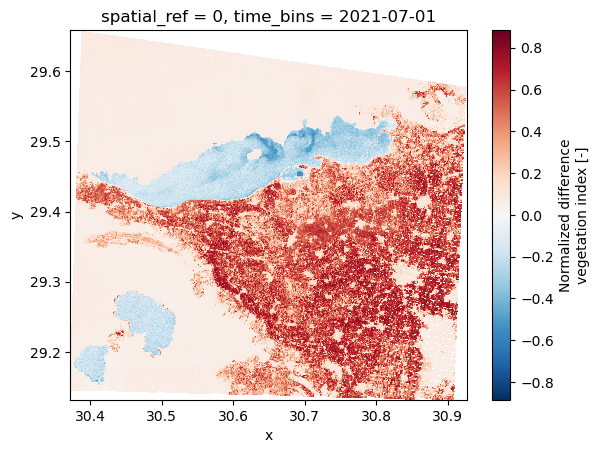

In [19]:
ds.ndvi.isel(time_bins=0).plot()